<title>
    # A model for binary multivariate time series


<h1 align=center> A model for binary multivariate time series generation </center>

In [2]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML, Image
from scipy.stats import ttest_ind_from_stats, spearmanr
from sklearn.preprocessing import StandardScaler
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import xlsxwriter 
import tqdm
import math
import xarray as xr
%matplotlib inline


## Data generation mechanism

In [993]:
def sample(i :int, T :int, d :int): 
    
    """
    Data generating function. Returns A, B,sigma as matrices, the sampled data as a tensor, and the latent state
    data as a tensor. 
    """

    A = 0.3*np.identity(d) + 0.1*np.random.randn(d,d)
    B = 0.8*np.identity(d)
    random_matrix = np.random.randn(d,d)
    sigma = np.dot(random_matrix,random_matrix.T)
    
    x_data = np.zeros((i,d,T))
    z_data = np.zeros((i,d,T))
    #dimension 0: individus, dimension 1: features, dimension 2: temps
    
    
    #initialization 
    x = np.random.randint(0,2,size=(d,i))
    z = np.random.randn(d,i)
    
    for t in np.arange(T): 
        z = A@x + B@z + np.random.multivariate_normal(mean=np.zeros(d),cov=sigma,size=i).T
        p = stats.norm.cdf(z)
        x = np.random.binomial(1,p,size=(d,i))
        x_data[:,:,t] = x.T
        z_data[:,:,t] = z.T
        
    return A,B,sigma,x_data,z_data
        
        
        

    

    

In [994]:
T=900
A,B,sigma,test_data,z_data = sample(100,T,d)

Text(0.5, 0, 'Time')

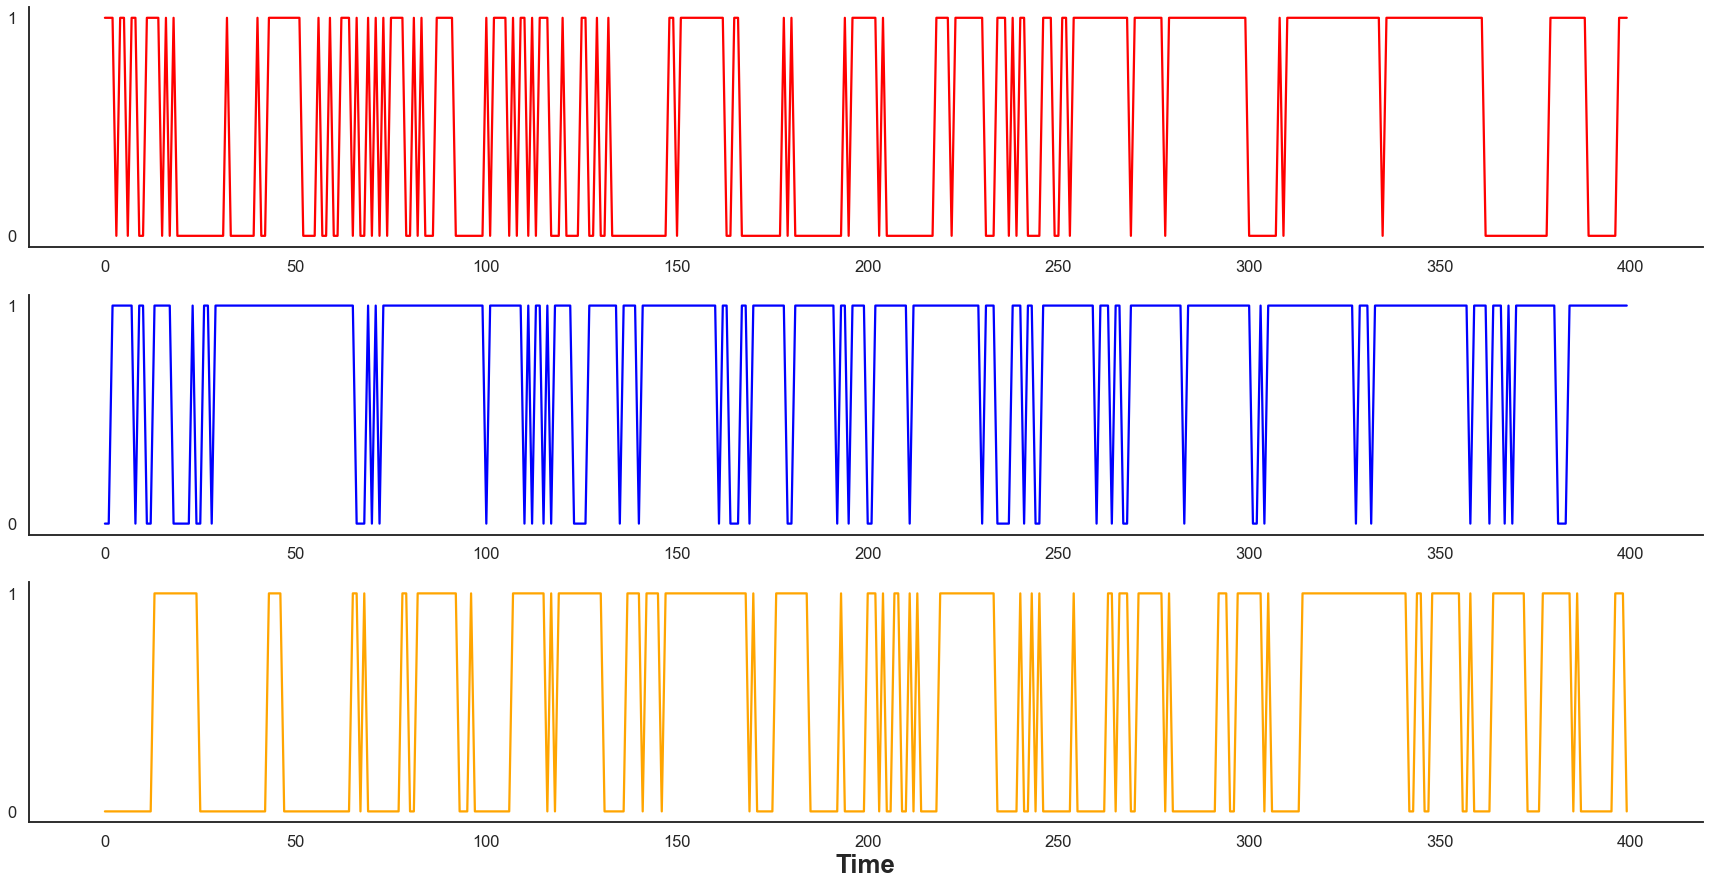

In [995]:
f,ax=plt.subplots(3,1,figsize=(30,15))

sns.set_context('talk')
sns.set_style('white')
ax[0].plot(test_data[4,0,500:], c='red')
ax[1].plot(test_data[4,1,500:], c='blue')
ax[2].plot(test_data[4,2,500:], c='orange')

for i in [0,1,2]:
    ax[i].set_yticks([0,1])
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["top"].set_visible(False)
    
ax[2].set_xlabel('Time', fontsize='x-large', fontweight='bold')

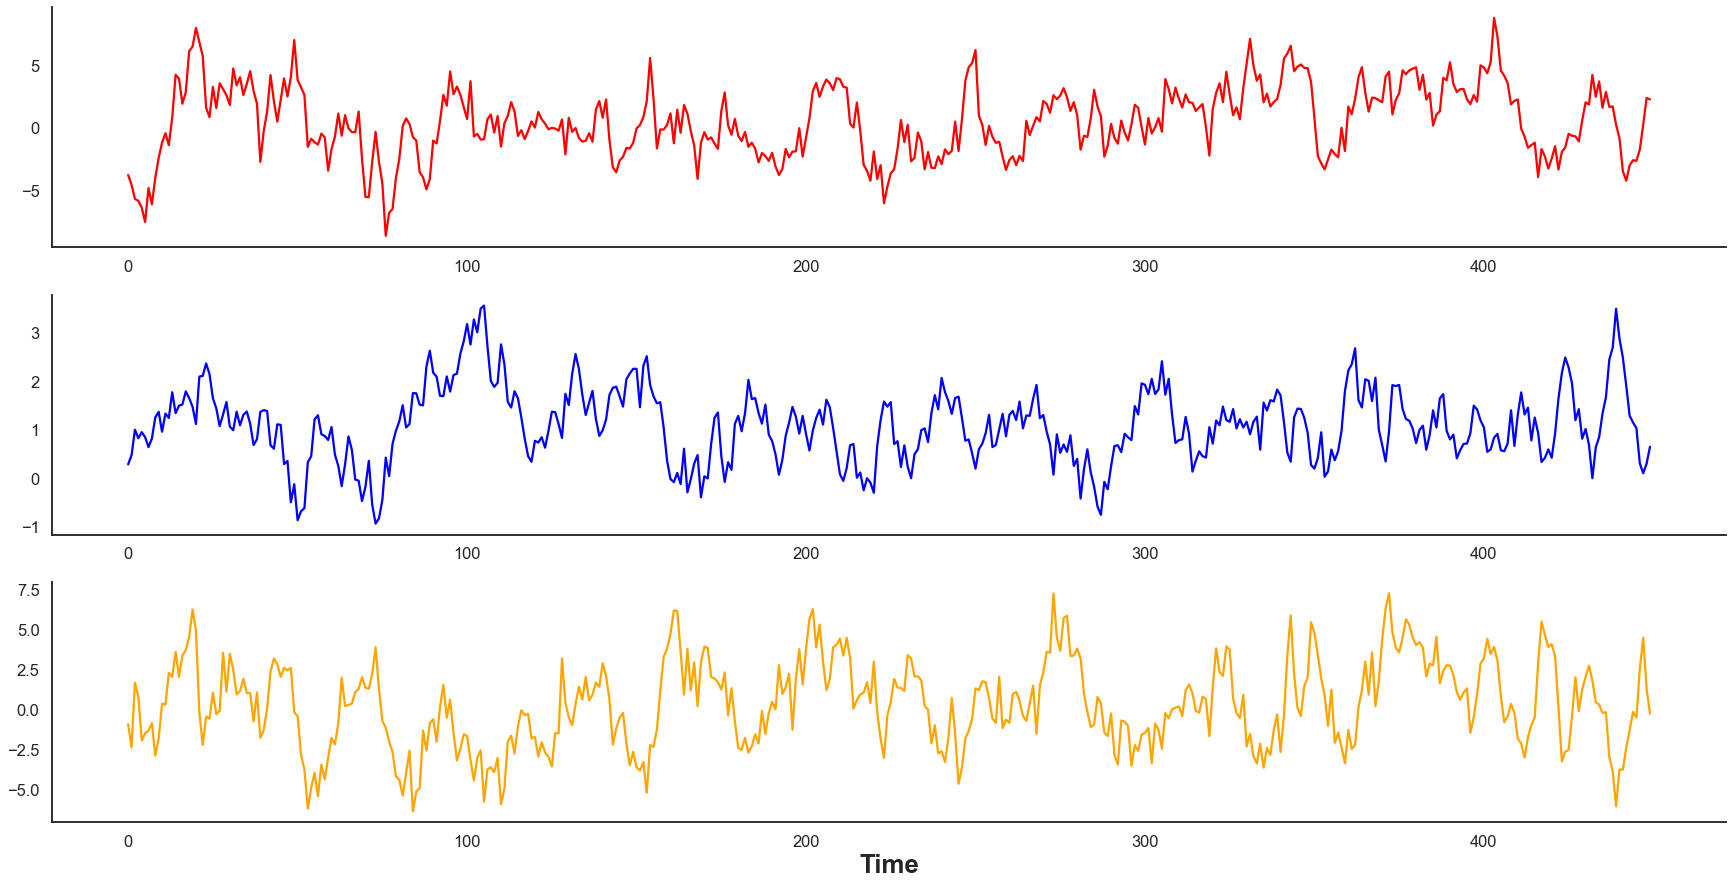

In [996]:
f,ax=plt.subplots(3,1,figsize=(30,15))

sns.set_context('talk')
sns.set_style('white')
ax[0].plot(z_data[4,0,int(T/2):], c='red')
ax[1].plot(z_data[4,1,int(T/2):], c='blue')
ax[2].plot(z_data[4,2,int(T/2):], c='orange')

ax[2].set_xlabel('Time', fontsize='x-large', fontweight='bold')

for i in [0,1,2]:
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["top"].set_visible(False)


<AxesSubplot:>

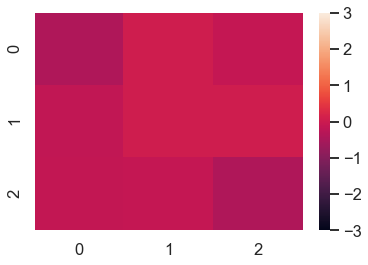

In [724]:
sns.heatmap(B,vmax=3,vmin=-3)

<AxesSubplot:>

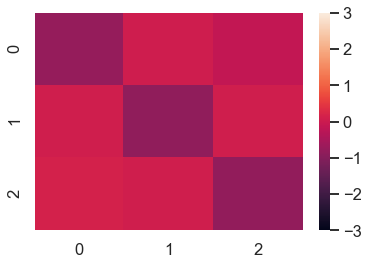

In [725]:
sns.heatmap(A,vmax=3,vmin=-3)

## Mean field approximation 

### Utils functions for mu gradient

In [754]:
def approx_mu_grad(var): 
    """
    Computes the full sum term in the mu gradient of the ELBO via MCMC approximation.
    """

    mu = var[0:d]
    sigmas = var[d:]
        
    epsilon = 1e-3
    
    #draw = np.random.randn(m,len(mu))
    transformed_draw = draw*sigmas + mu
    approx_1 = stats.norm.pdf(transformed_draw)/(np.maximum(stats.norm.cdf(transformed_draw),epsilon))
    approx_2 = stats.norm.pdf(transformed_draw)/np.maximum((1-stats.norm.cdf(transformed_draw)),epsilon)
    approx_1 = approx_1.mean(axis=0)
    approx_2 = approx_2.mean(axis=0)
    data_1 = np.multiply(data.sum(axis=2),approx_1).sum(axis=0)
    data_2 = np.multiply((1-data).sum(axis=2),approx_2).sum(axis=0)
    full_data = data_1 + data_2
    
    return full_data

In [755]:
def elbo_mu_grad(var):
    
    """
    Computes the gradient of the ELBO w.r.t. sigma. Returns a (d,) array. 
    """
    
    mu = var[0:d]
    sigmas = var[d:]
    
    quadratic_term = (-T*N*mu.T@((np.identity(d)-B).T)@sigma_inv@(np.identity(d)-B)).reshape(d,1)
        
    time_sum = (-np.matmul(A,data[:,:,:-1]).sum(axis=(2,0)).T@sigma_inv@(B-np.identity(d))).reshape(d,1)
        
    exp_sum = approx_mu_grad(var).reshape(d,1)
    
    return quadratic_term + time_sum + exp_sum

### Utils functions for sigma gradient

In [756]:
def approx_sigma_grad(var): 
    
    """
    Computes the full sum term in the mu gradient of the ELBO via MCMC approximation. 
    """
    
    d = data.shape[1]

    mu = var[0:d]
    sigmas = var[d:]
    T = data.shape[2]
    
    epsilon = 1e-3
        
    #draw = np.random.randn(m,len(mu))
    transformed_draw = draw*sigmas + mu
    approx_1 = draw*stats.norm.pdf(transformed_draw)/(np.maximum(stats.norm.cdf(transformed_draw),epsilon))
    approx_2 = draw*stats.norm.pdf(transformed_draw)/(np.maximum(1-stats.norm.cdf(transformed_draw),epsilon))
    approx_1 = approx_1.mean(axis=0)
    approx_2 = approx_2.mean(axis=0)
    data_1 = np.multiply(data.sum(axis=2),approx_1).sum(axis=0)
    data_2 = np.multiply((1-data).sum(axis=2),approx_2).sum(axis=0)
    full_data = data_1 - data_2
    
    return full_data

In [757]:
def elbo_sigma_grad(var): 
    
    """
    Computes the gradient of the ELBO w.r.t. sigma. Returns a (d,) array. 
    """
    
    mu = var[0:d]
    sigmas = var[d:]
    
    diag_term = -(T*N*np.diag(sigma_inv+B.T@sigma_inv@B)*sigmas).reshape(d,1)
    entropy_term = -((T*N)/sigmas).reshape(d,1)
    exp_sum = approx_sigma_grad(var).reshape(d,1)
    
    return diag_term + entropy_term + exp_sum

### Other utils

In [758]:
def compute_expectation(var): 
    
    """
    Approximates the full sum term in the ELBO. Returns a scalar.
    """
    
    mu = var[0:d]
    sigmas = var[d:]
    epsilon = 1e-3
    
    
    #draw = np.random.randn(m,len(mu))
    transformed_draw = draw*sigmas + mu
    approx_1 = np.log(np.maximum(stats.norm.cdf(transformed_draw),epsilon))
    approx_2 = np.log(np.maximum(1-stats.norm.cdf(transformed_draw),epsilon))
    approx_1 = approx_1.mean(axis=0)
    approx_2 = approx_2.mean(axis=0)
    data_1 = np.multiply(data.sum(axis=2),approx_1).sum(axis=0)
    data_2 = np.multiply((1-data).sum(axis=2),approx_2).sum(axis=0)
    full_data = data_1 + data_2
    return full_data.sum()
    

In [759]:
def elbo(var):
    
    """
    Computes the ELBO(evidence lower bound) of the model. Returns -ELBO, a scalar, in order to cast the maximization
    problem as a minimization problem.
    """
    
    mu = var[0:d]
    sigmas = var[d:]
    
    entropy_term = -(T*N/2)*(d*np.log(2*math.pi)+d*np.log(2*math.pi*math.e)+np.linalg.slogdet(sigma)[1]+2*np.log(sigmas).sum())
    
    expectation_term = compute_expectation(var)
    
    bilinear_term = -(T*N/2)*mu.T@(sigma_inv - 2*sigma_inv@B + B.T@sigma_inv@B)@mu
    
    norm_term = -1/2*(np.matmul(A,data[:,:,:-1]).sum(axis=(2,0))).T@sigma_inv@(np.matmul(A,data[:,:,:-1]).sum(axis=(2,0)))
    
    time_sum = (-(np.matmul(A,data[:,:,:-1]).sum(axis=(2,0)).T)@sigma_inv@(B-np.identity(d)))@mu
    
    diag_term = -T*N/2*(np.diag(sigma_inv+B.T@sigma_inv@B)*(sigmas**2)).sum()
    
    elbo_value = -float((entropy_term + expectation_term + diag_term + time_sum + norm_term))
        
    return 1/N*elbo_value

In [763]:
def full_jacobian(var): 
    
    """
    Util function that returns minus the full jacobian of the ELBO (needed for scipy.optimize). 
    """
    
    mu_grad = elbo_mu_grad(var)
    sigma_grad = elbo_sigma_grad(var)
    
    full_grad = np.array([mu_grad,sigma_grad]).reshape((2*d,))
    
    return -1/N*full_grad

### Optimization with SCIPY.OPTIMIZE

In [969]:
import scipy.optimize as optim
import scipy.stats as stats

In [970]:
d = 3
N=100
T= 50

In [971]:
A,B,sigma,data,latent_state = sample(i=N,T=T,d=d)

In [972]:
sigma_inv = np.linalg.inv(sigma)

In [973]:
scipy.optimize.minimize(elbo,x0 = 6*np.ones(2*d),jac=full_jacobian, method='bfgs',bounds=[None,None,None,0,0,0])


/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:536: RuntimeWarning: Method bfgs cannot handle constraints nor bounds.
  RuntimeWarning)


      fun: nan
 hess_inv: array([[ 9.66204098e-01,  6.16753139e-02, -1.69963077e-01,
        -1.66206354e-03,  1.53404726e-02, -9.32731011e-04],
       [ 6.16753139e-02,  9.00501725e-01,  3.40227487e-01,
         4.20554926e-02,  7.52671275e-02, -1.79945010e-02],
       [-1.69963077e-01,  3.40227487e-01,  2.14391616e-01,
         8.14159424e-02,  3.13884923e-01, -5.64671965e-02],
       [-1.66206354e-03,  4.20554926e-02,  8.14159424e-02,
         1.11646132e+00,  3.07905602e-01, -6.86120909e-02],
       [ 1.53404726e-02,  7.52671275e-02,  3.13884923e-01,
         3.07905602e-01,  1.78629010e+00, -3.06920447e-01],
       [-9.32731011e-04, -1.79945010e-02, -5.64671965e-02,
        -6.86120909e-02, -3.06920447e-01,  5.33507411e-02]])
      jac: array([ 2750.31834349, -4867.33577315, 14096.77342682,   497.16408846,
        -953.53234806, 17724.89479679])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 14
      nit: 3
     njev: 13
   status: 2
  succes

In [974]:
draw = np.random.randn(1000,d)
print(scipy.optimize.check_grad(elbo,grad=full_jacobian, x0= 0.9*np.ones(2*d)))
print(scipy.optimize.check_grad(elbo,grad=full_jacobian, x0= 1*np.ones(2*d)))
print(scipy.optimize.check_grad(elbo,grad=full_jacobian, x0= 2*np.ones(2*d)))
print(scipy.optimize.check_grad(elbo,grad=full_jacobian, x0= 3*np.ones(2*d)))

2593.548190615509
2884.9196894068136
5829.178196211833
8778.206308894336


### CA optimization 

The cell bellow performs coordinate-wise optimization.

In [979]:
#Max iterations of coordinate descent and max iterations for every gradient descent within coordinate descent
max_it = 10
max_it_gd = 1000


#Initialization
variables = 4*np.ones(2*d) 

#Matrices to save values

variables_track = np.zeros((2*d,max_it*max_it_gd))

elbo_track = np.zeros(max_it)

for iteration in np.arange(max_it):
    
    optimization_order = np.random.permutation(np.arange(2*d))
    
    for i in optimization_order:
        
        for it in np.arange(max_it_gd):
            
            draw = np.random.randn(400,d)
            
            grad_noise = np.sqrt(0.0001/((iteration*max_it_gd + it + 1)**(0.55)))*np.random.randn(1)
            
            if i in np.arange(d,2*d):
                
                #This loop is for optimization of the variance parameters. 
                
                lr=0.00001/(iteration*max_it_gd + it + 1)
                
                #Gradient (as well as ELBO) is normalized by the number of individuals.
                
                grad = (-1/N)*elbo_sigma_grad(variables)[i-d]
                
                variables[i] = np.maximum(variables[i] - lr*grad + grad_noise,1e-18)
                
                
            else: 
                
                #This loop is for optimization of the mean parameters. 
                
                lr=0.001
                
                grad = (-1/N)*elbo_mu_grad(variables)[i]
                
                variables[i] = variables[i] - lr*grad + grad_noise
        
            variables_track[i,iteration*max_it_gd+it] = variables[i]
    
    elbo_track[iteration] = elbo(variables) 
    
    if iteration%2 ==0:
        
        print('Iteration ', iteration, ' completed.')
        print('ELBO value:', elbo_track[iteration])
        print('Current parameters values:', variables)
        
        

/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in matmul
  


Iteration  0  completed.
ELBO value: nan
Current parameters values: [        nan 10.75534672         nan  4.00040494  3.77947192         nan]
Iteration  2  completed.
ELBO value: nan
Current parameters values: [nan nan nan nan nan nan]
Iteration  4  completed.
ELBO value: nan
Current parameters values: [nan nan nan nan nan nan]


KeyboardInterrupt: 

In [946]:
print(variables)

[ 0.52452493 -0.22500612  0.44691329  1.89655903  2.04072583  1.88564669]


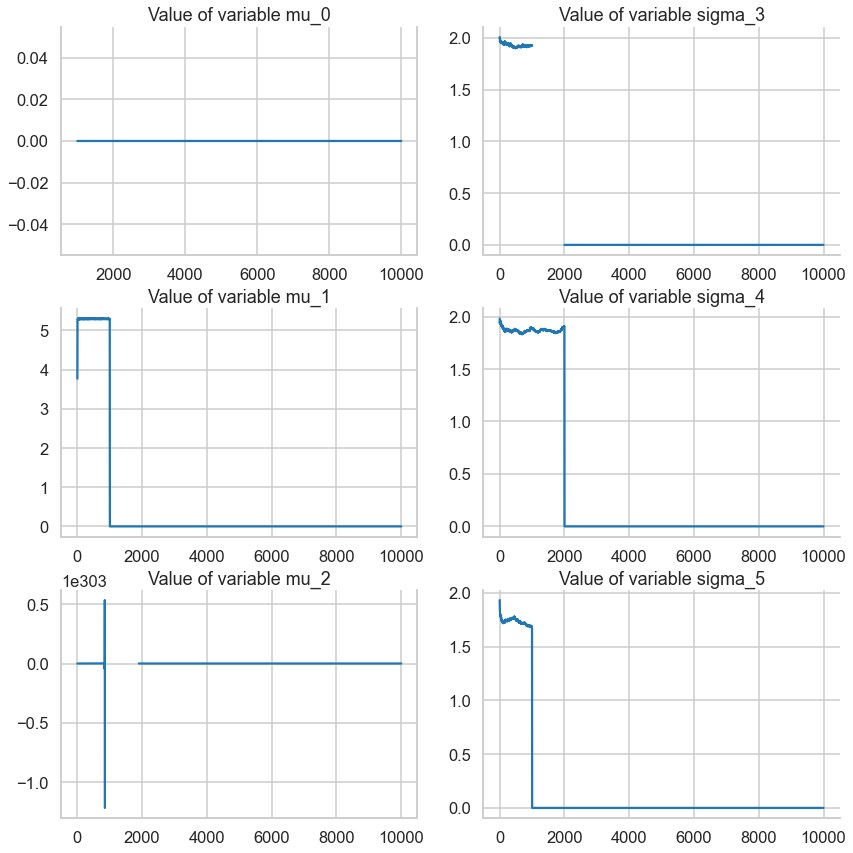

In [976]:
f,ax = plt.subplots(d,2,figsize=(12,12))
f.tight_layout()

for i in np.arange(2*d):
    
    sns.set_style('whitegrid')
    
    if i < d:
        ax[i,0].plot(variables_track[i,:], label='Value')
        ax[i,0].set_title('Value of variable mu_{}'.format(i))
        ax[i,0].spines["top"].set_visible(False)
        ax[i,0].spines["top"].set_visible(False)
    else:
        ax[i-d,1].plot(variables_track[i,:], label='Value')
        ax[i-d,1].set_title('Value of variable sigma_{}'.format(i))
        ax[i-d,1].spines["right"].set_visible(False)
        ax[i-d,1].spines["top"].set_visible(False)

[nan  0.  0.  0.  0.  0.  0.  0.  0.  0.]


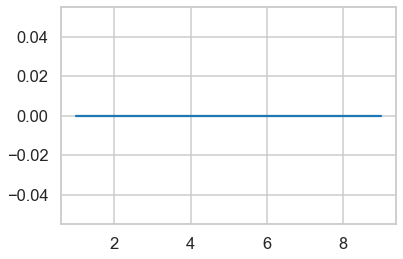

In [977]:
plt.plot(-elbo_track)

print(elbo_track)

### Vanilla GD

The cell bellow performs vanilla gradient descent for maximization of the ELBO. 

In [997]:
#Max iterations of coordinate descent and max iterations for every gradient descent within coordinate descent

max_it_gd = 4000
lr=0.000001

#Initialization
variables = 5*np.ones(2*d) 

#Matrices to save values

variables_track = np.zeros((2*d,max_it_gd))

elbo_track = np.zeros(max_it_gd)

for it in np.arange(max_it_gd):

    draw = np.random.randn(400,d)

    grad_noise = np.sqrt(0.00001/((it + 1)**(0.55)))*np.random.randn(1)
    
    gradient = full_jacobian(variables)
    
    variables = variables - lr*gradient + grad_noise


    variables_track[:,it] = variables
    elbo_track[it] = elbo(variables) 

    if it%100 ==0:

        print('Iteration ', it, ' completed.')
        print('ELBO value:', elbo_track[it])
        print('Current parameters values:', variables)

Iteration  0  completed.
ELBO value: 1271770.8160101692
Current parameters values: [5.00029456 5.00559558 4.99218351 4.97963715 4.9224093  4.50839138]
Iteration  100  completed.
ELBO value: nan
Current parameters values: [ 4.83144159  5.29198896  4.11418563  3.15850884  0.96151642 -0.05257552]
Iteration  200  completed.
ELBO value: nan
Current parameters values: [ 4.70144118  5.4946775   3.44638725  1.98183979  0.28014055 -0.26033488]
Iteration  300  completed.
ELBO value: nan
Current parameters values: [ 4.6143967   5.64965976  2.95303715  1.22190346  0.05647725 -0.0582065 ]
Iteration  400  completed.
ELBO value: 13715.468546462876
Current parameters values: [4.54836467 5.75846545 2.5777599  0.70220463 0.5038443  0.00798343]
Iteration  500  completed.
ELBO value: 10680.541472383544
Current parameters values: [4.49096018 5.82457076 2.28419136 0.27991547 0.2629819  0.01883194]
Iteration  600  completed.
ELBO value: nan
Current parameters values: [ 4.45502959  5.87388204  2.06570226 -0.2

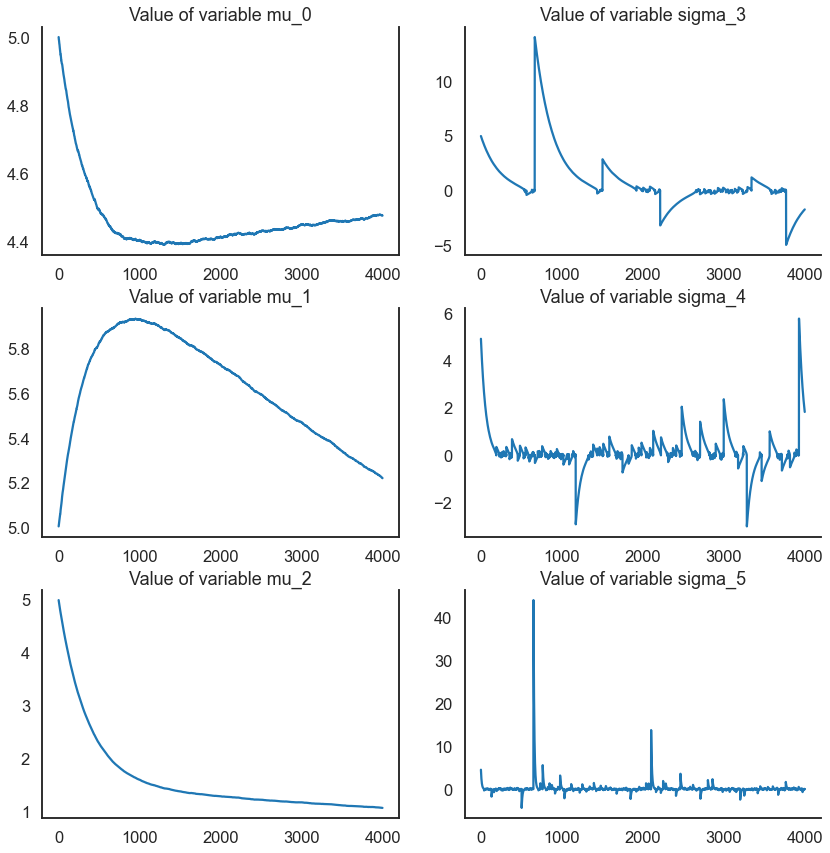

In [998]:
f,ax = plt.subplots(d,2,figsize=(12,12))
f.tight_layout()

for i in np.arange(2*d):
    
    sns.set_style('whitegrid')
    
    if i < d:
        ax[i,0].plot(variables_track[i,:], label='Value')
        ax[i,0].set_title('Value of variable mu_{}'.format(i))
        ax[i,0].spines["top"].set_visible(False)
        ax[i,0].spines["top"].set_visible(False)
    else:
        ax[i-d,1].plot(variables_track[i,:], label='Value')
        ax[i-d,1].set_title('Value of variable sigma_{}'.format(i))
        ax[i-d,1].spines["right"].set_visible(False)
        ax[i-d,1].spines["top"].set_visible(False)



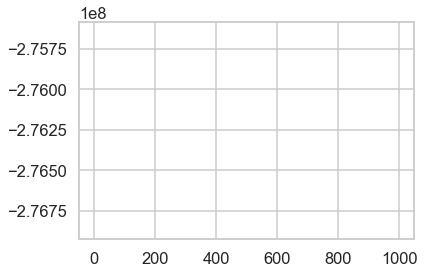

In [967]:
plt.plot(-elbo_track)